# Scale Maximum Amplitude CSVs 
Make maximum amplitude heatplots and SNR plots from the csvs computed in `make_csv.ipnb`. There is additional functionality not currently used which is able to adjust the node lines by the intersections - this is the `ratio` and `get_ratios` functions. There are a couple of other investigations that didn't prove fruitful later on in the notebook and I've left those codes as is. 

In [12]:
include("/Users/julianschmitt/Documents/Schoolwork/Seismology/C4-Project.jl/src/SeisCore.jl")
using .SeisCore, SeisIO, SeisNoise, Plots, Dates, CSV, DataFrames, JLD2, Statistics, Glob, ColorSchemes, 
            Plots.PlotUtils, HDF5, Images, Statistics, AbstractFFTs

σs = 0.5:0.1:2
normal_x = -5:0.01:5
normal_y = [exp.(-normal_x.^2 / (2σ^2)) / (2π * σ^2) for σ in σs];
loadcolorscheme(:cm_maxamp,ColorSchemes.gist_heat.colors[end-30:-1:1], "maxamp color", "for waveform plot");

In [2]:
loadcolorscheme(:cm_snr,ColorSchemes.winter.colors[end:-1:1], "snr color", "for snr waveform plot");
loadcolorscheme(:snr_comp,ColorSchemes.vik.colors, "snr comp", "for snr comparison");

In [13]:
# Get CSV filepathing
root = "/Volumes/T7/seis_data/final_maxamp_csvs/PGV_0.1_0.35"
all_stations = DataFrame(CSV.File("/Users/julianschmitt/Downloads/updated_sources.csv"))
files = joinpath.(root, readdir(root))

In [7]:
function ratio(vnodes, b1nodes, df)
    node_df = filter(x-> any(x.station .== vnodes),df)
    B1_df = filter(x-> any(x.station .== b1nodes),df)
    #println(node_df.station, B1_df.station)
    ratio = mean(B1_df.max_amp_mean)/mean(node_df.max_amp_mean)
    return ratio
end
function get_ratios(df::DataFrame)
    G2 = ["NO.G20$elt" for elt in collect(23:27)]
    B1_G2 = ["NO.B10$elt" for elt in collect(14:18)]
    G2_ratio = ratio(G2, B1_G2, df)
    #println(G2_ratio)

    G1 = ["NO.G10$elt" for elt in collect(22:27)]
    B1_G1 = ["NO.B10$elt" for elt in collect(47:53)]
    G1_ratio = ratio(G1, B1_G1, df)
    #println(G1_ratio)

    G3 = ["NO.G30$elt" for elt in collect(15:17)]
    B1_G3 = ["NO.B10$elt" for elt in collect(85:92)]
    G3_ratio = ratio(G3, B1_G3, df)
    #println(G3_ratio)

    G4 = ["NO.G40$(lpad(elt,2,'0'))" for elt in collect(9:13)]
    B1_G4 = ["NO.B11$elt" for elt in collect(10:16)]
    G4_ratio = ratio(G4, B1_G4, df)
    #println(G4_ratio)

    B3 = ["NO.B3$elt" for elt in collect(20:29)]
    B1_B3 = ["NO.B11$elt" for elt in collect(88:99)]
    B3_ratio = ratio(B3, B1_B3, df)
    #println(B3_ratio)

    B5 = ["NO.B50$elt" for elt in collect(34:38)]
    B1_B5 = ["NO.B12$elt" for elt in collect(16:22)]
    B5_ratio = ratio(B5, B1_B5, df)
    #println(B5_ratio)

    B2 = ["NO.B2$elt" for elt in collect(30:37)]
    B1_B2 = ["NO.B12$elt" for elt in collect(55:60)]
    B2_ratio = ratio(B2, B1_B2, df)
    #println(B2_ratio)

    B6 = ["NO.B600$elt" for elt in collect(1:5)]
    B1_B6 = ["NO.B12$elt" for elt in collect(55:60)]
    B6_ratio = ratio(B6, B1_B6, df)
    #println(B6_ratio)


    B4 = ["NO.B40$elt" for elt in collect(20:25)]
    B1_B4 = ["NO.B11$elt" for elt in collect(54:59)]
    B4_ratio = ratio(B4, B1_B4, df)
    #println(B4_ratio)
    
    d = Dict([("B1",1),("G2", G2_ratio), ("G1", G1_ratio), ("G3", G3_ratio), ("G4", G4_ratio),
            ("B3", B3_ratio), ("B5",B5_ratio), ("B2", B2_ratio), ("B6",B6_ratio), ("B4", B4_ratio)])
    return d
end
    

get_ratios (generic function with 1 method)

In [8]:
function clean_markers(markers::Array{Float64,1})
    mn, sd = mean(markers), std(markers)
    new_markers = Array{Float64,1}(undef, 0)
    num_changed = 0
    t = 3 # threshold - eg 2, 2.5, 3 standard deviations...
    for m in markers
        if m > mn+t*sd
            push!(new_markers, mn+t*sd)
            num_changed +=1
        elseif m < mn - t*sd
            push!(new_markers, mn - t*sd)
            num_changed +=1
        else
            push!(new_markers, m)
        end
    end
    return new_markers
    println("Box cleaning affected $num_changed nodes.")
end

clean_markers (generic function with 1 method)

## Following is current maxamp plot script

In [14]:
rootdir = "/Users/julianschmitt/Desktop/SeisPlots2/"
bandpass_filter = [0.1, 0.35]
for f in files
    df = DataFrame(CSV.File(f))
    source, comp = split(f, "_")[end-1], f[end-5:end-4]
    println(source)
    s_loc = LLE_geo("CI", source, all_stations)
    #println(s_loc)
    source_df = DataFrame(lon = [s_loc.lon], lat=[s_loc.lat])
    
    # calculate ratios and adjust markers
    #dict = get_ratios(df)
    #scales = [dict[convert(String, sta[4:5])] for sta in df.station]
    
    markers = clean_markers(df.max_amp_anti_mean .*10^(12))# .*scales)    
    # get plot bounds from nodes and source
    ylims = (minimum(vcat(df.lat_mean, s_loc.lat))-0.03, maximum(vcat(df.lat_mean, s_loc.lat))+0.03)
    xlims = (minimum(vcat(df.lon_mean, s_loc.lon))-0.03, maximum(vcat(df.lon_mean, s_loc.lon))+0.03)
    heatplot= Plots.scatter(df.lon_mean,df.lat_mean, marker_z = markers, ylims=ylims, xlims=xlims, 
        markerstrokewidth=0, markersize=5, color = :cm_maxamp, colorbar_title="Maximum Amplitude Scale (*10^12)",
        title="$source $comp Nodal Heatplot Anticausal, filt $(bandpass_filter[1]) - $(bandpass_filter[2])",
        ylabel= "Latitude", xlabel="Longitude", legend=:bottomleft, label="Nodes")
    Plots.scatter!(heatplot, source_df.lon, source_df.lat, color="green",markershape= :star5, markersize=7,
        label="Source")
    Plots.scatter!(heatplot, size=(800,400),dpi=300)
    filepath=joinpath(rootdir, "final_maxamp/maxamp_$(source)_$(comp)_nodal.png")
    DIR = dirname(filepath)
    if !isdir(DIR)
        mkpath(DIR)
    end
    png(heatplot, filepath)
end

### END of basic heatmap codes ###

In [17]:
rootdir = "/Volumes/T7/seis_data/SeisPlots2/"
root = "/Volumes/T7/seis_data/linear_nodestack_updated_snr/PGV_0.1_0.2"
all_stations = DataFrame(CSV.File("/Users/julianschmitt/Downloads/updated_sources.csv"))
files = joinpath.(root, readdir(root))
bandpass_filter = [0.1, 0.2]
for f in files
    df = DataFrame(CSV.File(f))
    source, comp = split(f, "_")[end-1], f[end-5:end-4]
    s_loc = LLE_geo(source, all_stations)
    #println(s_loc)
    source_df = DataFrame(lon = [s_loc.lon], lat=[s_loc.lat])
    
    # calculate ratios and adjust markers
    dict = get_ratios(df)
    scales = [dict[convert(String, sta[4:5])] for sta in df.station]
#     markers = clean_markers(df.max_amp_mean .*10^(12))# .*scales)    
    # get plot bounds from nodes and source
    ylims = [minimum(vcat(df.lat_mean, s_loc.lat))-0.03, maximum(vcat(df.lat_mean, s_loc.lat))+0.03]
    xlims = [minimum(vcat(df.lon_mean, s_loc.lon))-0.03, maximum(vcat(df.lon_mean, s_loc.lon))+0.03]
#     heatplot= Plots.scatter(df.lon_mean,df.lat_mean, marker_z = markers, ylims=(ylims[1], ylims[2]), xlims=(xlims[1], xlims[2]), 
#         markerstrokewidth=0, markersize=5, color = :cm_maxamp, colorbar_title="Maximum Amplitude Scale",
#         title="$source $comp Nodal Heatplot for all years, filt $(bandpass_filter[1]) - $(bandpass_filter[2])",
#         ylabel= "Latitude", xlabel="Longitude", legend=:bottomleft, label="Nodes")
#     Plots.scatter!(heatplot, source_df.lon, source_df.lat, color="green",markershape= :star5, markersize=7,
#         label="Source")
#     Plots.scatter!(heatplot, size=(800,400),dpi=300)
#     filepath=joinpath(rootdir, "heatplot_scaled_no_adjust/maxamp_$(source)_$(comp)_nodal.png")
#     DIR = dirname(filepath)
#     if !isdir(DIR)
#         mkpath(DIR)
#     end
#     png(heatplot, filepath)
    
#     # same for scaled maxamps
#     markers = clean_markers(df.max_amp_mean .*10^(12) .*scales)    
#     heatplot= Plots.scatter(df.lon_mean,df.lat_mean, marker_z = markers, ylims=(ylims[1], ylims[2]), xlims=(xlims[1], xlims[2]), 
#         markerstrokewidth=0, markersize=5, color = :cm_maxamp, colorbar_title="Maximum Amplitude Scale",
#         title="$source $comp Nodal Heatplot for all years, filt $(bandpass_filter[1]) - $(bandpass_filter[2])",
#         ylabel= "Latitude", xlabel="Longitude", legend=:bottomleft, label="Nodes")
#     Plots.scatter!(heatplot, source_df.lon, source_df.lat, color="green",markershape= :star5, markersize=7,
#         label="Source")
#     Plots.scatter!(heatplot, size=(800,400),dpi=300)
#     filepath=joinpath(rootdir, "heatplot_scaled_adjusted/maxamp_$(source)_$(comp)_nodal.png")
#     DIR = dirname(filepath)
#     if !isdir(DIR)
#         mkpath(DIR)
#     end
#     png(heatplot, filepath)
    
    # same for SNR - no need to scale ratios 
    markers = clean_markers(df.SNR_anticausal_mean)
    heatplot= Plots.scatter(df.lon_mean,df.lat_mean, marker_z = markers, ylims=(ylims[1], ylims[2]), xlims=(xlims[1], xlims[2]), 
        markerstrokewidth=0, markersize=5, color = :cm_snr, colorbar_title="Maximum Amplitude Scale",
        title="$source $comp Linear Nodal SNR Plot, filt $(bandpass_filter[1]) - $(bandpass_filter[2])",
        ylabel= "Latitude", xlabel="Longitude", legend=:bottomleft, label="Nodes")
    Plots.scatter!(heatplot, source_df.lon, source_df.lat, color="green",markershape= :star5, markersize=7,
        label="Source")
    Plots.scatter!(heatplot, size=(800,400),dpi=300)
    filepath=joinpath(rootdir, "heatplot_snr_anti_linear/snr_$(source)_$(comp)_nodal.png")
    DIR = dirname(filepath)
    if !isdir(DIR)
        mkpath(DIR)
    end
    png(heatplot, filepath)
end

In [98]:
robust = DataFrame(CSV.File("/Volumes/T7/seis_data/robust_nodestack/PGV_0.1_0.35/PGV_SVD_ZZ.csv")).SNR_anticausal_mean
linear = DataFrame(CSV.File("/Volumes/T7/seis_data/amplitude_nodestack/PGV_0.1_0.35/PGV_SVD_ZZ.csv")).SNR_anticausal_mean;

In [20]:
#Plots.histogram(robust, title=" Histogram of Robust SNRs for Anticausal SVD 0.1-0.35 HZ", legend=false)
root1 = "/Volumes/T7/seis_data/robust_nodestack_updated_snr/PGV_0.1_0.2"
root2 = "/Volumes/T7/seis_data/linear_nodestack_updated_snr/PGV_0.1_0.2"
frobust = joinpath.(root1, readdir(root1))
flinear = joinpath.(root2, readdir(root2))

108-element Array{String,1}:
 "/Volumes/T7/seis_data/linear_nodestack_updated_snr/PGV_0.1_0.2/PGV_BRE_EE.csv"
 "/Volumes/T7/seis_data/linear_nodestack_updated_snr/PGV_0.1_0.2/PGV_BRE_EN.csv"
 "/Volumes/T7/seis_data/linear_nodestack_updated_snr/PGV_0.1_0.2/PGV_BRE_EZ.csv"
 "/Volumes/T7/seis_data/linear_nodestack_updated_snr/PGV_0.1_0.2/PGV_BRE_NE.csv"
 "/Volumes/T7/seis_data/linear_nodestack_updated_snr/PGV_0.1_0.2/PGV_BRE_NN.csv"
 "/Volumes/T7/seis_data/linear_nodestack_updated_snr/PGV_0.1_0.2/PGV_BRE_NZ.csv"
 "/Volumes/T7/seis_data/linear_nodestack_updated_snr/PGV_0.1_0.2/PGV_BRE_ZE.csv"
 "/Volumes/T7/seis_data/linear_nodestack_updated_snr/PGV_0.1_0.2/PGV_BRE_ZN.csv"
 "/Volumes/T7/seis_data/linear_nodestack_updated_snr/PGV_0.1_0.2/PGV_BRE_ZZ.csv"
 "/Volumes/T7/seis_data/linear_nodestack_updated_snr/PGV_0.1_0.2/PGV_CHN_EE.csv"
 "/Volumes/T7/seis_data/linear_nodestack_updated_snr/PGV_0.1_0.2/PGV_CHN_EN.csv"
 "/Volumes/T7/seis_data/linear_nodestack_updated_snr/PGV_0.1_0.2/PGV_CHN_EZ.csv"

In [63]:
# Makes SNR comparison Plot between robust and linear SNR
tags = [split(f, "/")[end] for f in frobust]
for t in tags
    # select robust and linear dataframes 
    fr = DataFrame(CSV.File(frobust[findall(x-> occursin(t, x), frobust)[1]]))[:, [:station, :lon_mean, :lat_mean, :SNR_anticausal_mean]]
    fl = DataFrame(CSV.File(flinear[findall(x -> occursin(t,x), flinear)[1]]))[:, [:station, :SNR_anticausal_mean]]
    rename!(fr, :SNR_anticausal_mean => :SNR_robust_anti)
    rename!(fl, :SNR_anticausal_mean => :SNR_linear_anti)
    # join on station name and add differences column
    m = innerjoin(fr, fl, on = :station)
    m.diff = m.SNR_robust_anti - m.SNR_linear_anti
    
    # get location 
    source, comp = split(t, "_")[end-1], t[end-5:end-4]
    s_loc = LLE_geo(source, all_stations)
    source_df = DataFrame(lon = [s_loc.lon], lat=[s_loc.lat])
    
    markers = clean_markers(m.diff)
    ylims = (minimum(vcat(m.lat_mean, s_loc.lat))-0.03, maximum(vcat(m.lat_mean, s_loc.lat))+0.03)
    xlims = (minimum(vcat(m.lon_mean, s_loc.lon))-0.03, maximum(vcat(m.lon_mean, s_loc.lon))+0.03)
    zlims = (-maximum(abs.(markers)), maximum(abs.(markers)))
    println(zlims)
    # make color range symmetric 
    heatplot= Plots.scatter(m.lon_mean,m.lat_mean, marker_z = markers, ylims=ylims, xlims=xlims, zlims = zlims, 
        markerstrokewidth=0, markersize=5, color = :snr_comp, colorbar_title="Difference in SNR: Robust - Linear",
        title="$source $comp Robust vs Linear Comparison, filt $(bandpass_filter[1]) - $(bandpass_filter[2])",
        ylabel= "Latitude", xlabel="Longitude", legend=:bottomleft, label="Nodes")
    Plots.scatter!(heatplot, source_df.lon, source_df.lat, color="green",markershape= :star5, markersize=7,
        label="Source")
    Plots.scatter!(heatplot, size=(800,400),dpi=300)
    filepath=joinpath(rootdir, "snr_comparison/SNRdiff_$(source)_$(comp)_nodal.png")
    DIR = dirname(filepath)
    if !isdir(DIR)
        mkpath(DIR)
    end
    png(heatplot, filepath)
end

(-1.8412097262511518, 1.8412097262511518)
(-1.8414475545469884, 1.8414475545469884)
(-1.6650841543902255, 1.6650841543902255)
(-1.5350208697295527, 1.5350208697295527)
(-1.5344187720796034, 1.5344187720796034)
(-1.525566322048082, 1.525566322048082)
(-1.915680994457512, 1.915680994457512)
(-1.994038197605851, 1.994038197605851)
(-2.3299668981507398, 2.3299668981507398)
(-5.375555977147076, 5.375555977147076)
(-5.251480639834615, 5.251480639834615)
(-6.509769122108851, 6.509769122108851)
(-4.569110159087937, 4.569110159087937)
(-6.20786361830314, 6.20786361830314)
(-4.174650724113356, 4.174650724113356)
(-6.0357731223078845, 6.0357731223078845)
(-6.090753629464952, 6.090753629464952)
(-7.266950216226793, 7.266950216226793)
(-5.442457429635239, 5.442457429635239)
(-3.537463330140251, 3.537463330140251)
(-5.065807898476452, 5.065807898476452)
(-4.523052650921773, 4.523052650921773)
(-5.071668971794283, 5.071668971794283)
(-5.502771977867512, 5.502771977867512)
(-5.934301642971234, 5.93430

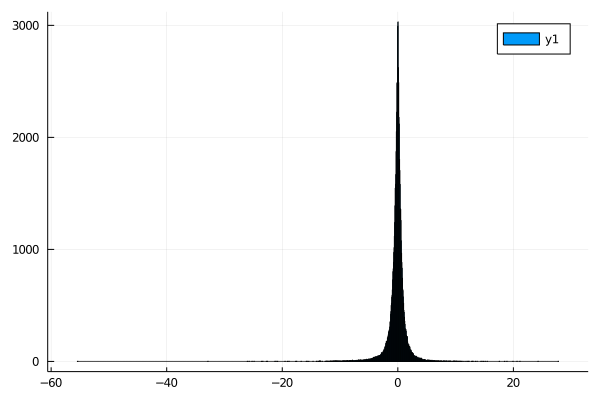

In [41]:
# get linear vs robust comparison 
all = []
for t in tags
    # select robust and linear dataframes 
    fr = DataFrame(CSV.File(frobust[findall(x-> occursin(t, x), frobust)[1]]))[:, [:station, :lon_mean, :lat_mean, :SNR_anticausal_mean]]
    fl = DataFrame(CSV.File(flinear[findall(x -> occursin(t,x), flinear)[1]]))[:, [:station, :SNR_anticausal_mean]]
    rename!(fr, :SNR_anticausal_mean => :SNR_robust_anti)
    rename!(fl, :SNR_anticausal_mean => :SNR_linear_anti)
    # join on station name and add differences column
    m = innerjoin(fr, fl, on = :station)
    m.diff = m.SNR_robust_anti - m.SNR_linear_anti
    push!(all, m.diff)
end
all = collect(Iterators.flatten(all))
histogram(all, xlims = (-10,10))



## Here we investigate combining files to strengthen waveguide effects and increase smoothing

In [60]:
rootdir = "/Users/julianschmitt/Desktop/SeisPlots2/"
bandpass_filter = [0.1, 0.35]
function plot_combined(files::Array{String, 1})
    source_df = DataFrame(lon = Float64[], lat = Float64[], source = String[], comp=String[])
    for f in files
        # get source info 
        source, comp = split(f, "_")[end-1], f[end-5:end-4]
        s_loc = LLE_geo(source, all_stations)
        push!(source_df, Dict("lon" => s_loc.lon, "lat" => s_loc.lat, "source" => source, "comp" => comp))
    end
    # join dataframes and aggregate
    #dfs = [DataFrame(CSV.File(f)) for f in files]
    df = DataFrame(CSV.File(files[1]))
    for f in files[2:end]
        df = vcat(df, DataFrame(CSV.File(f)))
    end
    df2 = df
    df = aggregate(groupby(df, :station), mean)
    all_source_names = join(Set(source_df.source), ", ", " and ")
    markers = clean_markers(df.max_amp_anti_mean_mean .*10^(12))# .*scales)  
    # get plot bounds from nodes and source
    ylims = (minimum(vcat(df.lat_mean_mean, source_df.lat))-0.03, maximum(vcat(df.lat_mean_mean, source_df.lat))+0.03)
    xlims = (minimum(vcat(df.lon_mean_mean, source_df.lon))-0.03, maximum(vcat(df.lon_mean_mean, source_df.lon))+0.03)
    heatplot= Plots.scatter(df.lon_mean_mean,df.lat_mean_mean, marker_z = markers, ylims=ylims, xlims=xlims, 
        markerstrokewidth=0, markersize=5, color = :maxamp2, colorbar_title="Maximum Amplitude Scale (*10^12)",
        title="$all_source_names Heatplot, filt $(bandpass_filter[1]) - $(bandpass_filter[2])",
        ylabel= "Latitude", xlabel="Longitude", legend=:bottomleft, label="Nodes")
    Plots.scatter!(heatplot, source_df.lon, source_df.lat, color="green",markershape= :star5, markersize=7,
        label="Source", series_annotations = source_df.source)
    Plots.scatter!(heatplot, size=(800,400),dpi=300)
    source_names = join(Set(source_df.source), "_")
    filepath=joinpath(rootdir, "source_combined/maxamp_ZZ_$(source_names).png")
    DIR = dirname(filepath)
    if !isdir(DIR)
        mkpath(DIR)
    end
    png(heatplot, filepath)
    #return df2
end

plot_combined (generic function with 1 method)

In [62]:
plot_combined(filter(x -> (occursin("SVD", x) || occursin("SNO", x) || occursin("DEV", x)) && occursin("ZZ", x), files))
plot_combined(filter(x -> (occursin("PASC", x) || occursin("RUS", x)) && occursin("ZZ", x), files))
plot_combined(filter(x -> (occursin("TA2", x) || occursin("LPC", x) || occursin("CJM", x))) && occursin("ZZ", x), files))
plot_combined(filter(x -> (occursin("SRN", x) || occursin("BRE", x))) && occursin("ZZ", x), files))
plot_combined(filter(x -> (occursin("SNO", x))) && occursin("ZZ", x), files))
plot_combined(files)






#plot_combined(files)

LoadError: [91msyntax: extra token ")" after end of expression[39m

In [46]:
test = filter(x -> occursin("NO.B1010", x.station),t)


,station,lat_mean,lon_mean,max_amp_mean,max_amp_anti_mean,max_amp_causal_mean
,String,Float64,Float64,Float64,Float64,Float64
1,NO.B1010,34.1067,-118.144,2.96399e-12,2.96399e-12,2.06781e-12
2,NO.B1010,34.1067,-118.144,3.04523e-12,3.04523e-12,2.0039e-12
3,NO.B1010,34.1067,-118.144,3.56394e-12,3.56394e-12,1.70061e-12
4,NO.B1010,34.1067,-118.144,3.82361e-12,3.82361e-12,1.55193e-12
5,NO.B1010,34.1067,-118.144,4.2295e-12,4.2295e-12,1.72123e-12
6,NO.B1010,34.1067,-118.144,5.05421e-12,5.05421e-12,2.17195e-12
7,NO.B1010,34.1067,-118.144,3.27959e-12,3.27959e-12,2.33015e-12
8,NO.B1010,34.1067,-118.144,2.20372e-12,2.20372e-12,2.12679e-12
9,NO.B1010,34.1067,-118.144,3.51644e-12,3.51644e-12,3.01421e-12


In [47]:
aggregate(groupby(test, :station), mean)

,station,lat_mean_mean,lon_mean_mean,max_amp_mean_mean,max_amp_anti_mean_mean
,String,Float64,Float64,Float64,Float64
1,NO.B1010,34.1067,-118.144,5.61283e-12,5.61283e-12


In [53]:
histogram(all, xlims = (-6,6), label = "Robust - Linear SNR", color = "green", alpha=0.6,
            title="Difference in SNR Value across Sources and Component", dpi=200)
png(joinpath(root, "robust_minus_linear_SNR.png"))


In [104]:
# Linear metrics
println("Linear median: ", median(linear))
println("Linear mean: ", mean(linear))
println("Linear standard deviation: ", std(linear))

Linear median: 5.275388464516443
Linear mean: 5.743440692038858
Linear standard deviation: 2.034614139452316


In [105]:
println("Robust median: ", median(robust))
println("Robust mean: ", mean(robust))
println("Robust standard deviation: ", std(robust))

Robust median: 5.177632635980827
Robust mean: 5.6083328153261025
Robust standard deviation: 2.0253066754088156


In [61]:
rootdir

"/Volumes/T7/seis_data/SeisPlots2/"

## Lets compare Linear and Robust SNR in greater detail!

In [115]:
files = readdir("/Volumes/T7/seis_data/robust_nodestack/PGV_0.1_0.35")
differences = Array{Float64, 1}(undef, 0)
for file in files
    robust = DataFrame(CSV.File("/Volumes/T7/seis_data/robust_nodestack/PGV_0.1_0.35/$file")).SNR_anticausal_mean
    linear = DataFrame(CSV.File("/Volumes/T7/seis_data/amplitude_nodestack/PGV_0.1_0.35/$file")).SNR_anticausal_mean;
    diff = mean(robust)-mean(linear)
    push!(differences, diff)
end
Plots.histogram(differences, legend=false, title="Difference in mean SNR between Robust and Linear max amps",
                xlabel="mean Robust SNR - mean Linear SNR by station", ylabel="Count")

<!DOCTYPE html>
 
 
 Plots.jl

In [112]:
for file in files
    df = DataFrame(CSV.File(file))
    
    df.max_amp_mean

72-element Array{String,1}:
 "PGV_BRE_EE.csv"
 "PGV_BRE_EN.csv"
 "PGV_BRE_EZ.csv"
 "PGV_BRE_NN.csv"
 "PGV_BRE_NZ.csv"
 "PGV_BRE_ZZ.csv"
 "PGV_CHN_EE.csv"
 "PGV_CHN_EN.csv"
 "PGV_CHN_EZ.csv"
 "PGV_CHN_NN.csv"
 "PGV_CHN_NZ.csv"
 "PGV_CHN_ZZ.csv"
 "PGV_CJM_EE.csv"
 ⋮
 "PGV_SVD_EE.csv"
 "PGV_SVD_EN.csv"
 "PGV_SVD_EZ.csv"
 "PGV_SVD_NN.csv"
 "PGV_SVD_NZ.csv"
 "PGV_SVD_ZZ.csv"
 "PGV_TA2_EE.csv"
 "PGV_TA2_EN.csv"
 "PGV_TA2_EZ.csv"
 "PGV_TA2_NN.csv"
 "PGV_TA2_NZ.csv"
 "PGV_TA2_ZZ.csv"